Moving to a new notebook, old one was getting bloated

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from scipy.interpolate import interpolate

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [4]:
import stistools

In [5]:
path = '/home/david/work/muscles/trappist-1/hst/g140m_cals/'

In [6]:
rawpath = path + 'all_obs/'
outpath = path + 'picked_trace_extracts/'

In [7]:
picks = Table.read('new_trace_centers.ecsv')

In [9]:
centers = []
for a, b in zip(picks['A2CENTER'], picks['UNCERTAIN']):
    if a == 0.0:
        centers.append(b)
    else:
        centers.append(a)

In [12]:
flts = glob.glob(rawpath+'*flt.fits')

In [14]:
os.environ['oref'] = rawpath

In [77]:

new_x1ds = glob.glob(outpath+'*new_x1d.fits')
if len(new_x1ds) > 0:
    [os.remove(x) for x in new_x1ds]

i = 0
for flt in flts:
    rootname = fits.getheader(flt,0)['ROOTNAME']
    #print(rootname)
    stistools.x1d.x1d(flt, output=outpath+rootname+'_new_x1d.fits', verbose=False, trailer='trace_recal.trl',a2center=centers[np.argwhere(picks['ROOTNAME']==rootname)[0][0]], 
                      maxsrch=0, bk1size=14, bk2size=14, bk1offst=-13, bk2offst=13)

new_x1ds = glob.glob(outpath+'*new_x1d.fits')                
print(len(new_x1ds))


85


In [34]:
lya = Table.read('../combined/bourrier_lya.txt', format ='ascii')
lw, lf = lya['WAVELENGTH'], lya['FLUX']

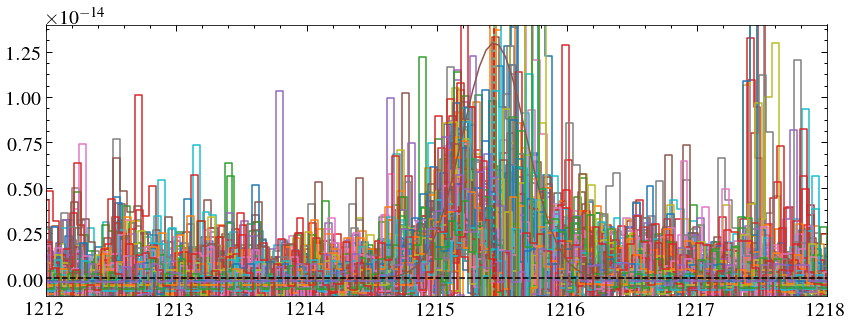

In [57]:
for x in new_x1ds:
    data = fits.getdata(x,1)[0]
    #date = fits.getheader(x, 0)['TDATEOBS']
   # if date in dates[0:3]:
    #    print(date)
    plt.step(data['WAVELENGTH'], data['FLUX'])
#    plt.step(data['WAVELENGTH'], data['ERROR'])
plt.plot(lw, lf)
plt.xlim(1212, 1218)

plt.ylim(-1e-15, 1.4e-14)
plt.axhline(0, c='k', ls ='--')
plt.axvline(1215.44, ls ='--', c='r')

In [78]:
f_new = []
e_new = []
i = 0
for x in new_x1ds:
    data = fits.getdata(x, 1)[0]
    if i == 0:
        w_new = data['WAVELENGTH']
        f_new.append(data['FLUX'])
        e_new.append(data['ERROR'])
    else:
        fi = interpolate.interp1d(data['WAVELENGTH'], data['FLUX'], fill_value='extrapolate')(w_new)
       # wi, fi = resample.bintogrid(data['WAVELENGTH'], data['FLUX'],  newx = w_new )
        f_new.append(fi)
        ei = interpolate.interp1d(data['WAVELENGTH'], data['ERROR'], fill_value='extrapolate')(w_new)
        e_new.append(ei)
    #plt.step(data['WAVELENGTH'], data['FLUX'])
    #f_new.append(data['FLUX'])
    i += 1
#w_new = data['WAVELENGTH']
f_new = np.mean(np.array(f_new), axis=0)
#f_new = np.average(f_new, weights = 1/np.array(e_new)
#e_new = np.mean(np.array(e_new), axis=0)
e_new = (np.sum(np.array(e_new)**2, axis=0)**0.5)/(i**0.5)



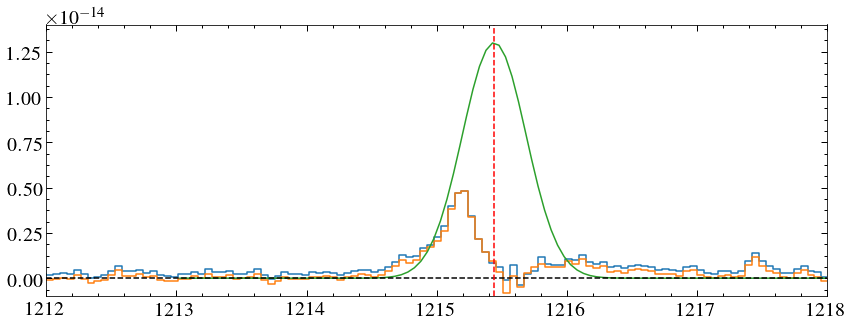

In [82]:
plt.step(w_new, f_new)
#plt.step(w_new, e_new)
#plt.step(w_full, f_full)
plt.plot(lw, lf)
plt.xlim(1212, 1218)

plt.ylim(-1e-15, 1.4e-14)
plt.axhline(0, c='k', ls ='--')
plt.axvline(1215.44, ls ='--', c='r')

In [45]:
dates = []
for x in new_x1ds:
    date = fits.getheader(x,0)['TDATEOBS']
    dates.append(date)
dates = np.unique(dates)
years = [d[0:4] for d in dates]
years = np.unique(years)
years

array(['2016', '2017', '2018'], dtype='<U4')

In [83]:
w_full, f_full, e_full = w_new, f_new, e_new

2016


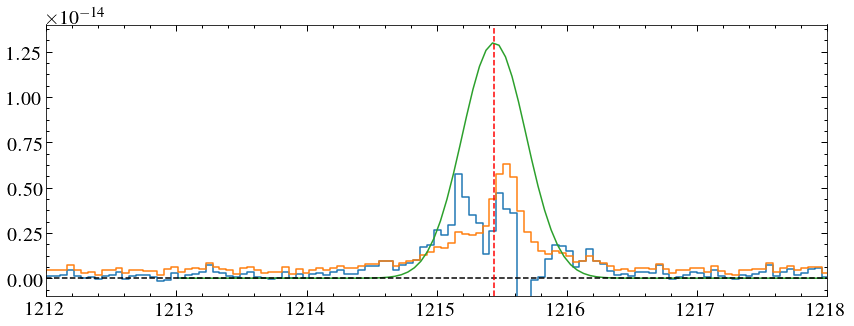

2017


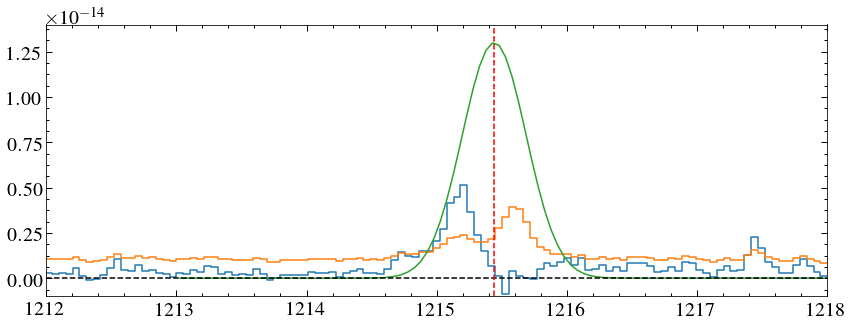

2018


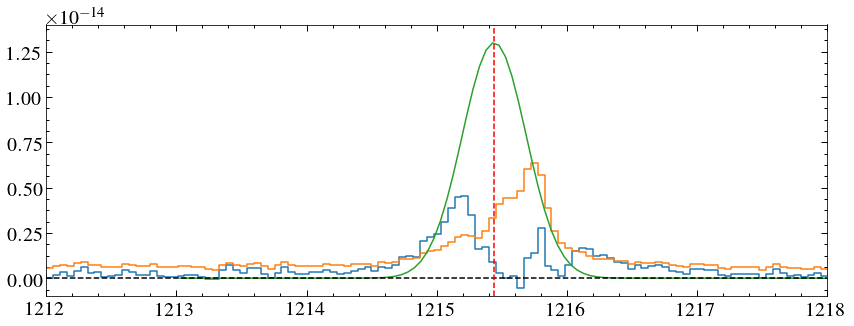

In [84]:
for year in years:
    print(year)
    f_new = []
    e_new = []
    i = 0
    for x in new_x1ds:
        date = fits.getheader(x,0)['TDATEOBS']
        if date[0:4] == year:
            data = fits.getdata(x, 1)[0]
            if i == 0:
                w_new = data['WAVELENGTH']
                f_new.append(data['FLUX'])
                e_new.append(data['ERROR'])
            else:
                fi = interpolate.interp1d(data['WAVELENGTH'], data['FLUX'], fill_value='extrapolate')(w_new)
                f_new.append(fi)
                ei = interpolate.interp1d(data['WAVELENGTH'], data['ERROR'], fill_value='extrapolate')(w_new)
                e_new.append(ei)
            i += 1
    f_new = np.mean(np.array(f_new), axis=0)
   # e_new = np.mean(np.array(e_new), axis=0)
    e_new = (np.sum(np.array(e_new)**2, axis=0)**0.5)/(i**0.5)

   # e_new = 
    plt.step(w_new, f_new)
    plt.step(w_new, e_new)
    plt.plot(lw, lf)
    plt.xlim(1212, 1218)

    plt.ylim(-1e-15, 1.4e-14)
    plt.axhline(0, c='k', ls ='--')
    plt.axvline(1215.44, ls ='--', c='r')
    plt.show()
   
    data = Table([w_new*u.AA, f_new*u.erg/u.cm**2/u.s/u.AA, e_new*u.erg/u.cm**2/u.s/u.AA], names = ['WAVELENGTH', 'FLUX', 'ERROR'] )
    ascii.write(data, 'extracted_spectra/TRAPPIST-1_G140M_'+year+'_mean.ecsv', delimiter=',', format='ecsv', overwrite=True)

Filtering out uncertian points

In [68]:
f_new = []
e_new = []
i = 0
for x in new_x1ds:
    rootname = fits.getheader(x,0)['ROOTNAME']
    if picks['A2CENTER'][np.argwhere(picks['ROOTNAME']==rootname)[0][0]] != 0.0:
        data = fits.getdata(x, 1)[0]
        if i == 0:
            w_new = data['WAVELENGTH']
            f_new.append(data['FLUX'])
            e_new.append(data['ERROR'])
        else:
            fi = interpolate.interp1d(data['WAVELENGTH'], data['FLUX'], fill_value='extrapolate')(w_new)
           # wi, fi = resample.bintogrid(data['WAVELENGTH'], data['FLUX'],  newx = w_new )
            f_new.append(fi)
            ei = interpolate.interp1d(data['WAVELENGTH'], data['ERROR'], fill_value='extrapolate')(w_new)
            e_new.append(ei)
        #plt.step(data['WAVELENGTH'], data['FLUX'])
        #f_new.append(data['FLUX'])
        i += 1
#w_new = data['WAVELENGTH']
f_new = np.mean(np.array(f_new), axis=0)
#f_new = np.average(f_new, weights = 1/np.array(e_new)
#e_new = np.mean(np.array(e_new), axis=0)
e_new = (np.sum(np.array(e_new)**2, axis=0)**0.5)/(i**0.5)

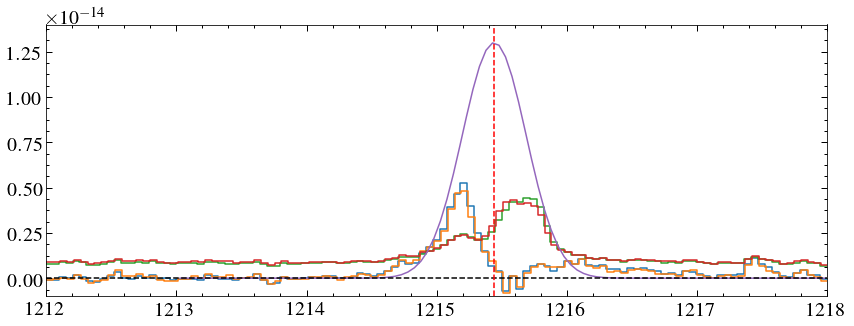

In [72]:
plt.step(w_new, f_new)
plt.step(w_full, f_full)
plt.step(w_new, e_new)
plt.step(w_full, e_full)
plt.plot(lw, lf)
plt.xlim(1212, 1218)

plt.ylim(-1e-15, 1.4e-14)
plt.axhline(0, c='k', ls ='--')
plt.axvline(1215.44, ls ='--', c='r')

2016


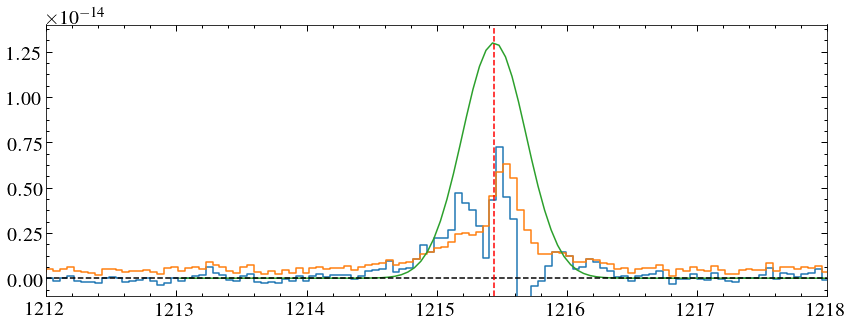

2017


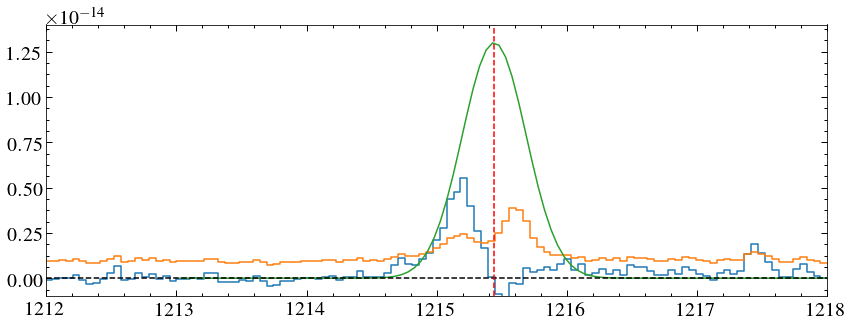

2018


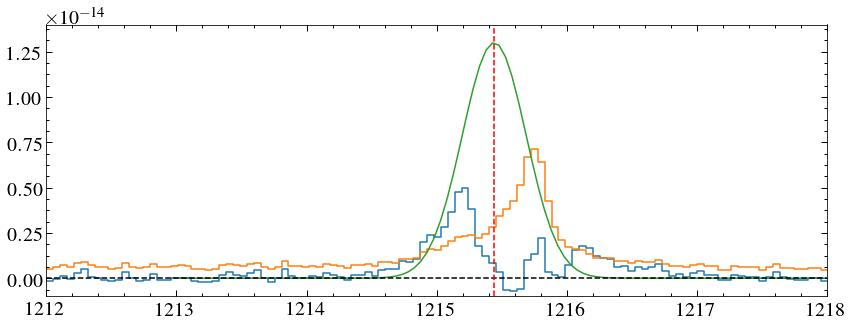

In [74]:
for year in years:
    print(year)
    f_new = []
    e_new = []
    i = 0
    for x in new_x1ds:
        date = fits.getheader(x,0)['TDATEOBS']
        rootname = fits.getheader(x,0)['ROOTNAME']
        if date[0:4] == year and picks['A2CENTER'][np.argwhere(picks['ROOTNAME']==rootname)[0][0]] != 0.0:
            data = fits.getdata(x, 1)[0]
            if i == 0:
                w_new = data['WAVELENGTH']
                f_new.append(data['FLUX'])
                e_new.append(data['ERROR'])
            else:
                fi = interpolate.interp1d(data['WAVELENGTH'], data['FLUX'], fill_value='extrapolate')(w_new)
                f_new.append(fi)
                ei = interpolate.interp1d(data['WAVELENGTH'], data['ERROR'], fill_value='extrapolate')(w_new)
                e_new.append(ei)
            i += 1
    f_new = np.mean(np.array(f_new), axis=0)
   # e_new = np.mean(np.array(e_new), axis=0)
    e_new = (np.sum(np.array(e_new)**2, axis=0)**0.5)/(i**0.5)

   # e_new = 
    plt.step(w_new, f_new)
    plt.step(w_new, e_new)
    plt.plot(lw, lf)
    plt.xlim(1212, 1218)

    plt.ylim(-1e-15, 1.4e-14)
    plt.axhline(0, c='k', ls ='--')
    plt.axvline(1215.44, ls ='--', c='r')
    plt.show()

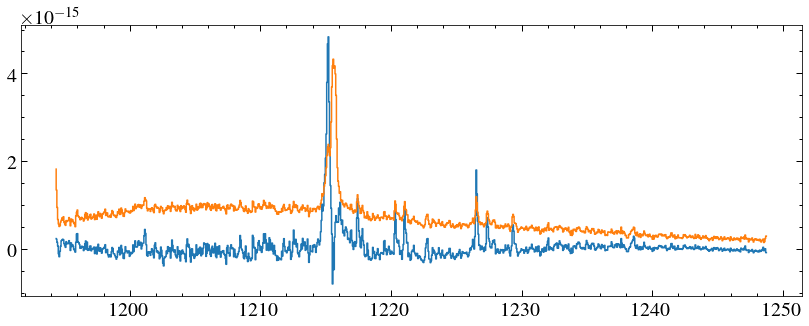

In [76]:
plt.step(w_full, f_full)
plt.step(w_full, e_full)

I think the filtering is unnesecary, it doesn't seem to affect the results

In [85]:
data = Table([w_full*u.AA, f_full*u.erg/u.cm**2/u.s/u.AA, e_full*u.erg/u.cm**2/u.s/u.AA], names = ['WAVELENGTH', 'FLUX', 'ERROR'] )
ascii.write(data, 'extracted_spectra/TRAPPIST-1_G140M_all_mean.ecsv', delimiter=',', format='ecsv', overwrite=True)

Experiment with data quality...

In [102]:
f_new = []
e_new = []
dq_new = []
i = 0
for x in new_x1ds:
    rootname = fits.getheader(x,0)['ROOTNAME']
    if picks['A2CENTER'][np.argwhere(picks['ROOTNAME']==rootname)[0][0]] != 0.0:
        data = fits.getdata(x, 1)[0]
        if i == 0:
            w_new = data['WAVELENGTH']
            f_new.append(data['FLUX'])
            e_new.append(data['ERROR'])
            dq_new.append(data['DQ'])
        else:
            fi = interpolate.interp1d(data['WAVELENGTH'], data['FLUX'], fill_value='extrapolate')(w_new)
           # wi, fi = resample.bintogrid(data['WAVELENGTH'], data['FLUX'],  newx = w_new )
            f_new.append(fi)
            ei = interpolate.interp1d(data['WAVELENGTH'], data['ERROR'], fill_value='extrapolate')(w_new)
            e_new.append(ei)
            dq_new.append(data['DQ'][0:len(w_new)])
        #plt.step(data['WAVELENGTH'], data['FLUX'])
        #f_new.append(data['FLUX'])
        i += 1
#w_new = data['WAVELENGTH']
f_mask = np.ma.masked_array(f_new, dq_new)
#f_new = np.ma.mean(np.array(f_new)[dq_new==0], axis=0)
f_new = np.ma.mean(f_mask, axis=0).data
#f_new = np.average(f_new, weights = 1/np.array(e_new)
#e_new = np.mean(np.array(e_new), axis=0)
e_mask = np.ma.masked_array(e_new, dq_new)
e_new = (np.sum(e_mask**2, axis=0)**0.5)/(i**0.5)

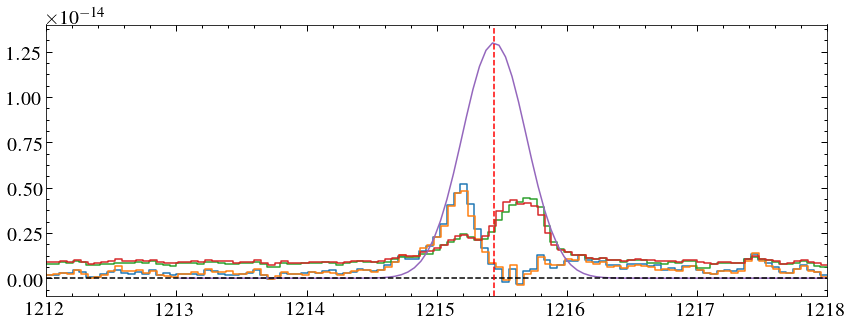

In [103]:
plt.step(w_new, f_new)
plt.step(w_full, f_full)
plt.step(w_new,e_new)
plt.step(w_full, e_full)
plt.plot(lw, lf)
plt.xlim(1212, 1218)

plt.ylim(-1e-15, 1.4e-14)
plt.axhline(0, c='k', ls ='--')
plt.axvline(1215.44, ls ='--', c='r')

2016


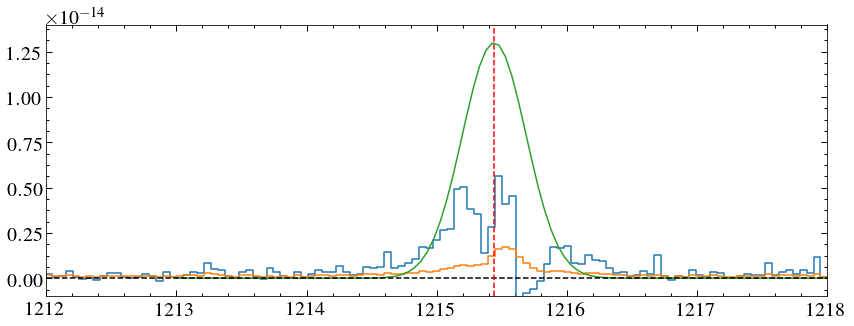

2017


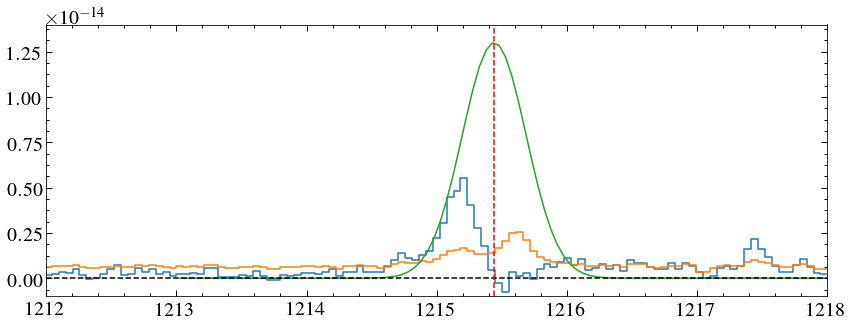

2018


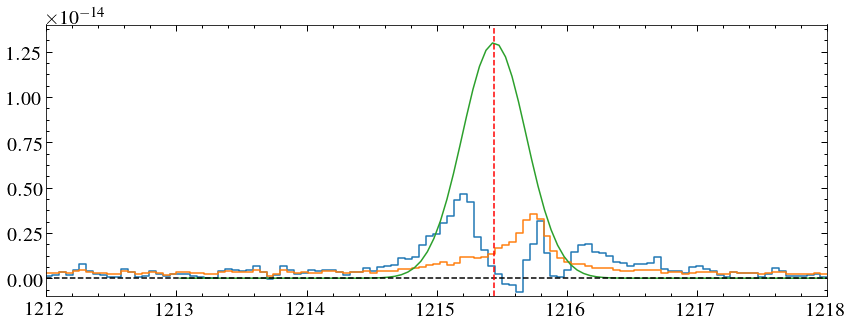

In [104]:
for year in years:
    print(year)
    f_new = []
    e_new = []
    dq_new = []
    i = 0
    for x in new_x1ds:
        date = fits.getheader(x,0)['TDATEOBS']
        rootname = fits.getheader(x,0)['ROOTNAME']
        if date[0:4] == year and picks['A2CENTER'][np.argwhere(picks['ROOTNAME']==rootname)[0][0]] != 0.0:
            data = fits.getdata(x, 1)[0]
            if i == 0:
                w_new = data['WAVELENGTH']
                f_new.append(data['FLUX'])
                e_new.append(data['ERROR'])
                dq_new.append(data['DQ'])
            else:
                fi = interpolate.interp1d(data['WAVELENGTH'], data['FLUX'], fill_value='extrapolate')(w_new)
                f_new.append(fi)
                ei = interpolate.interp1d(data['WAVELENGTH'], data['ERROR'], fill_value='extrapolate')(w_new)
                e_new.append(ei)
                dq_new.append(data['DQ'][0:len(w_new)])
        #plt.step(data['WAVELENGTH'], data['FLUX'])
        #f_new.append(data['FLUX'])
        i += 1
    f_mask = np.ma.masked_array(f_new, dq_new)
    #f_new = np.ma.mean(np.array(f_new)[dq_new==0], axis=0)
    f_new = np.ma.mean(f_mask, axis=0).data
    #f_new = np.average(f_new, weights = 1/np.array(e_new)
    #e_new = np.mean(np.array(e_new), axis=0)
    e_mask = np.ma.masked_array(e_new, dq_new)
    e_new = (np.sum(e_mask**2, axis=0)**0.5)/(i**0.5)


   # e_new = 
    plt.step(w_new, f_new)
    plt.step(w_new, e_new)
    plt.plot(lw, lf)
    plt.xlim(1212, 1218)

    plt.ylim(-1e-15, 1.4e-14)
    plt.axhline(0, c='k', ls ='--')
    plt.axvline(1215.44, ls ='--', c='r')
    plt.show()

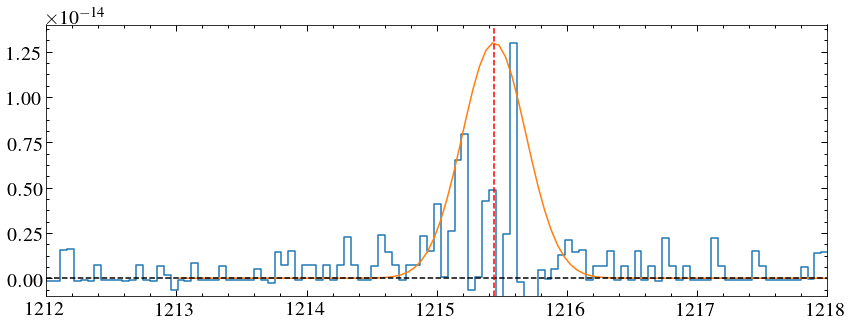

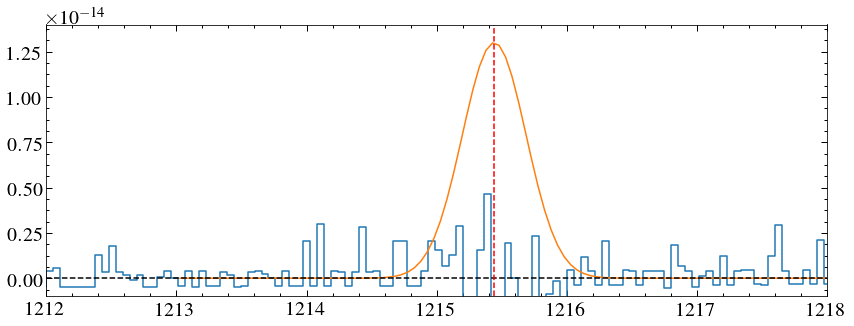

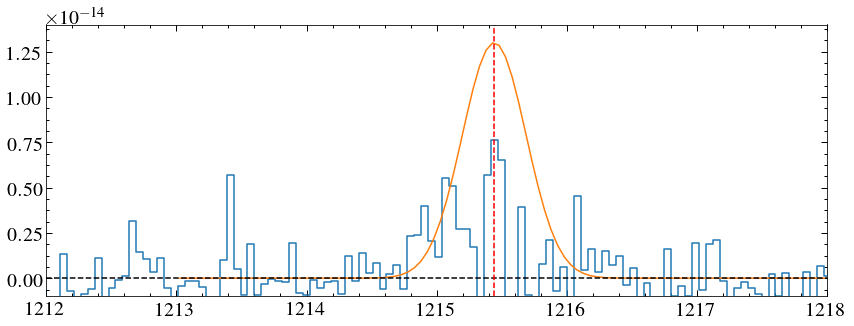

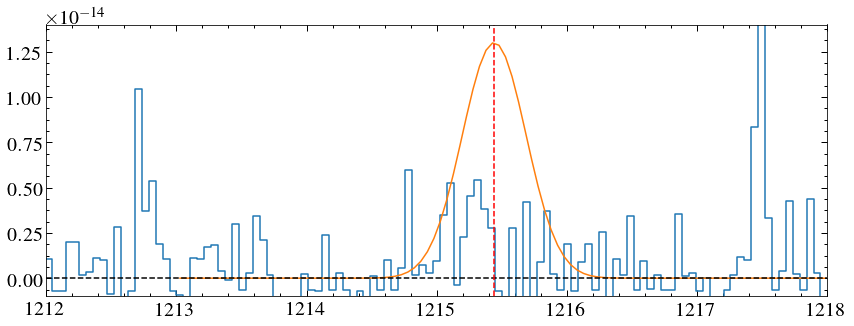

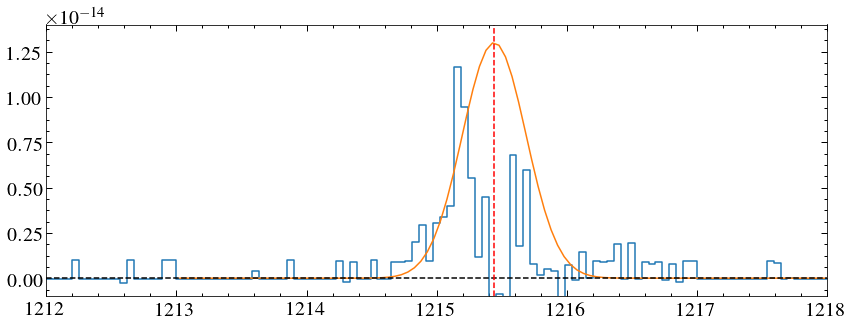

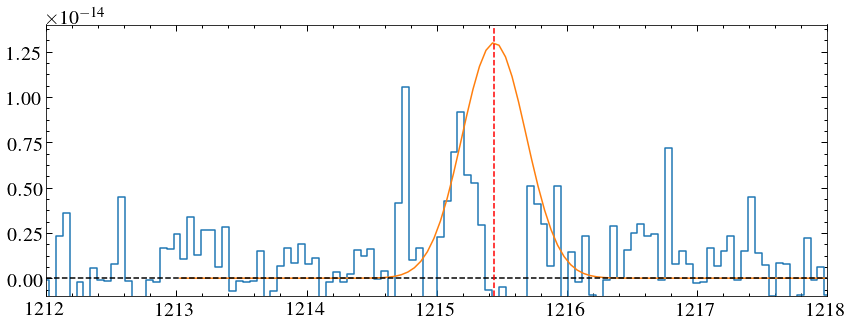

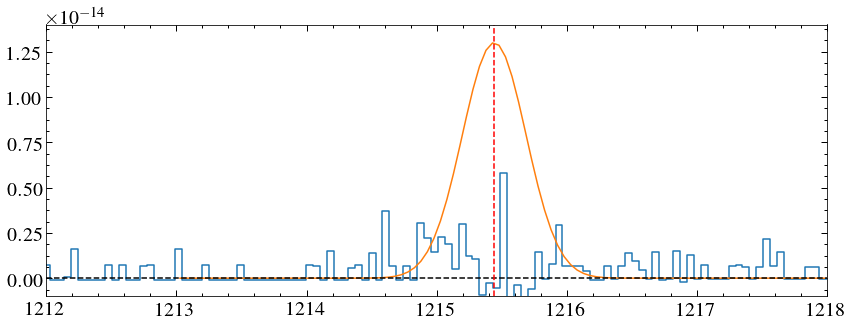

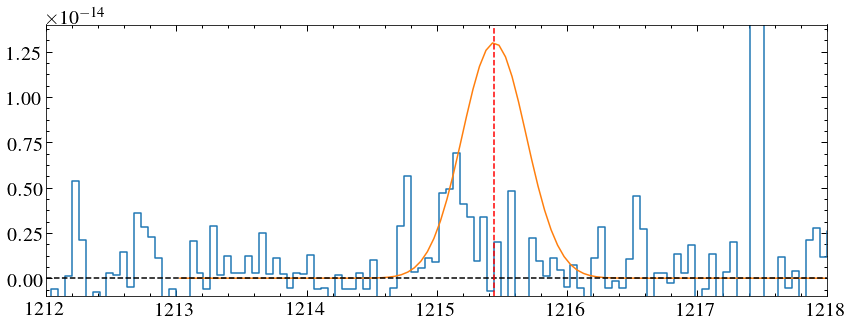

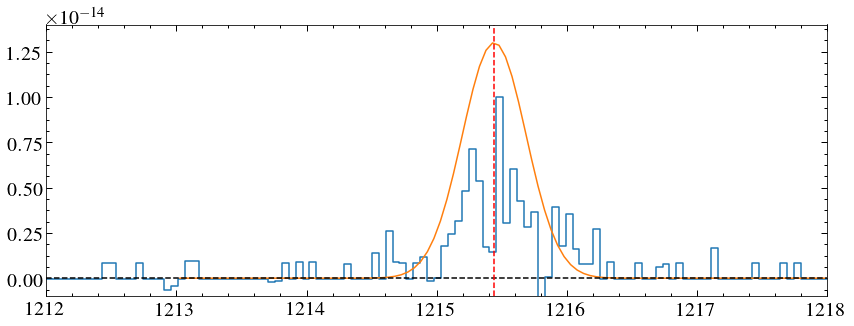

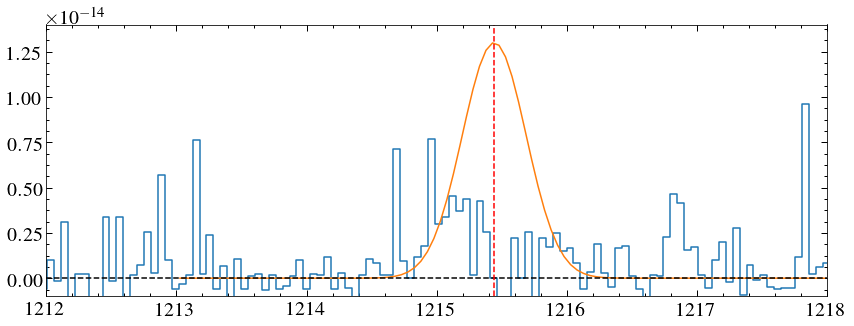

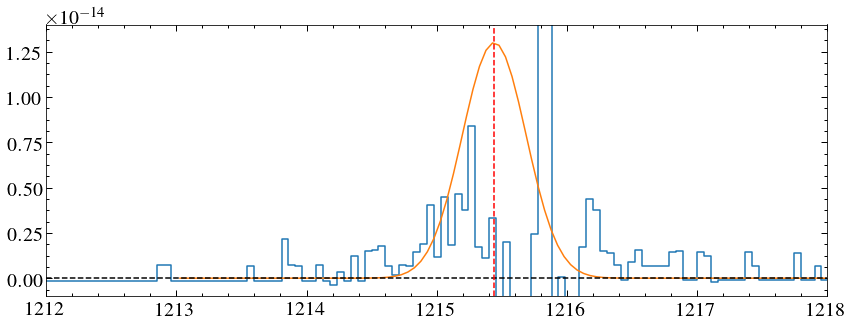

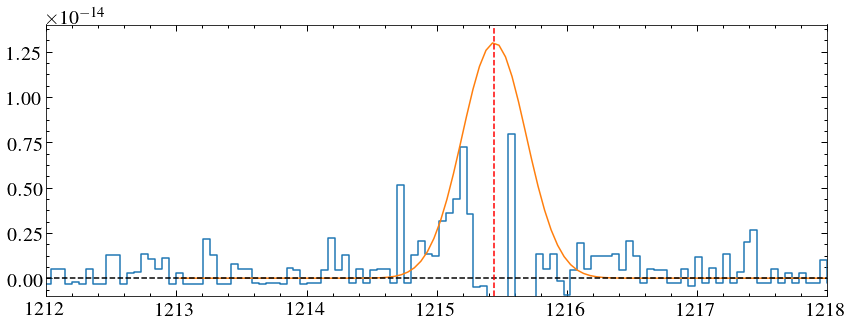

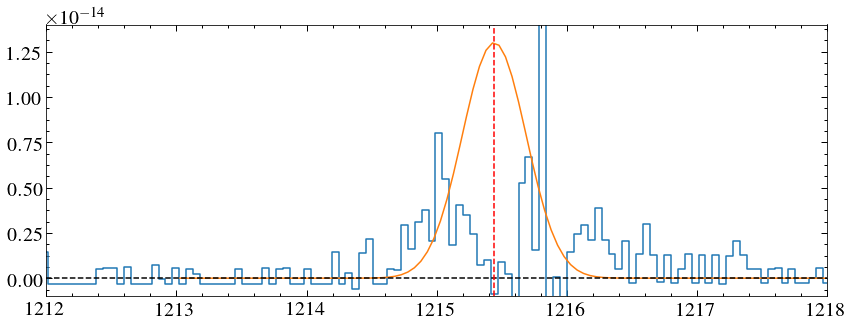

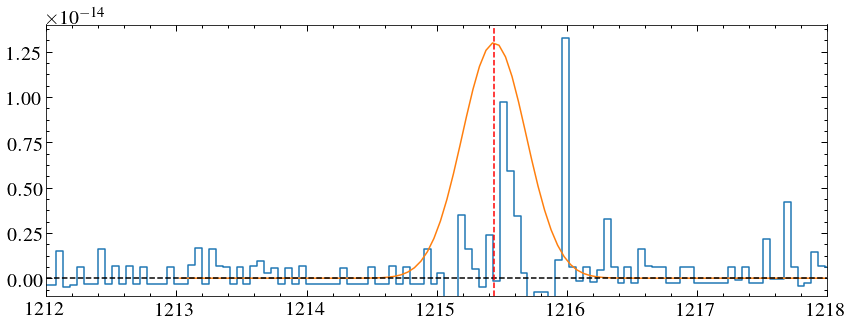

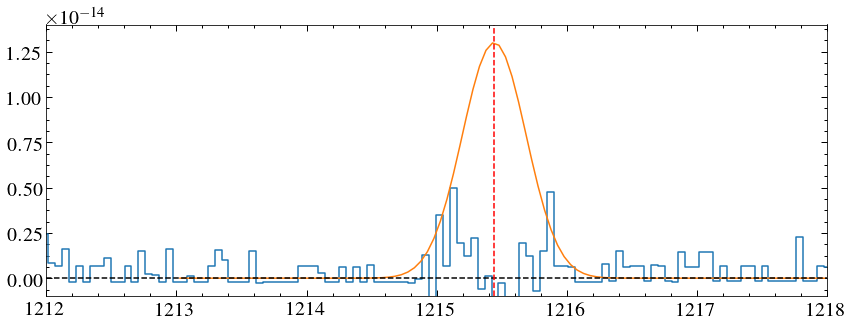

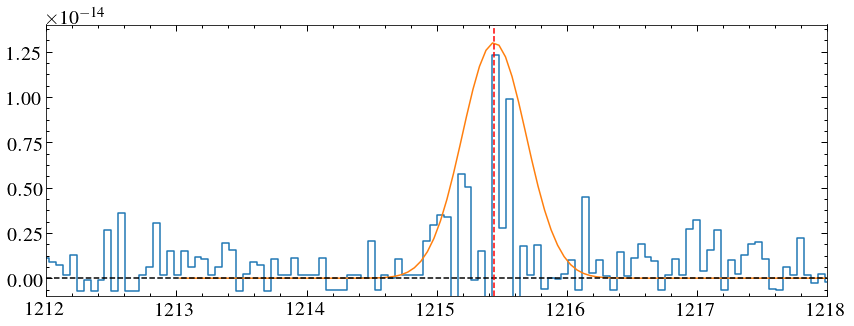

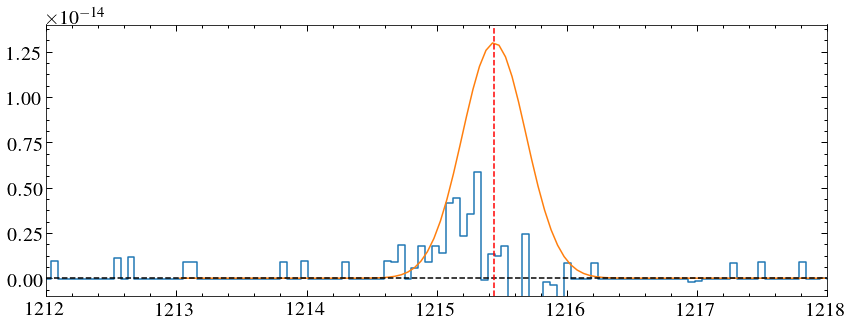

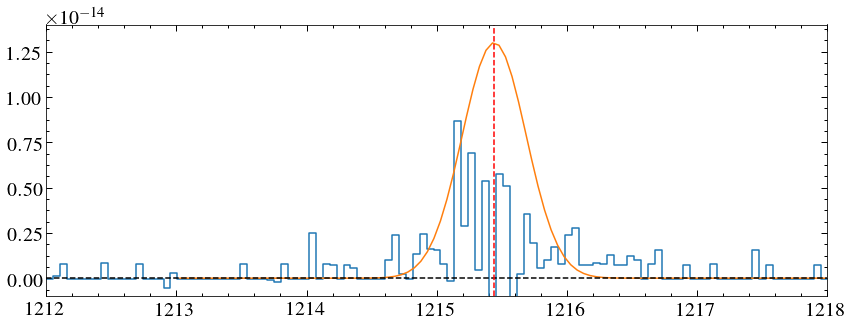

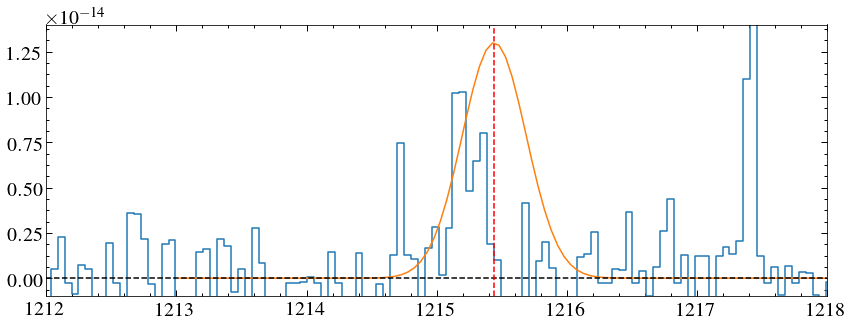

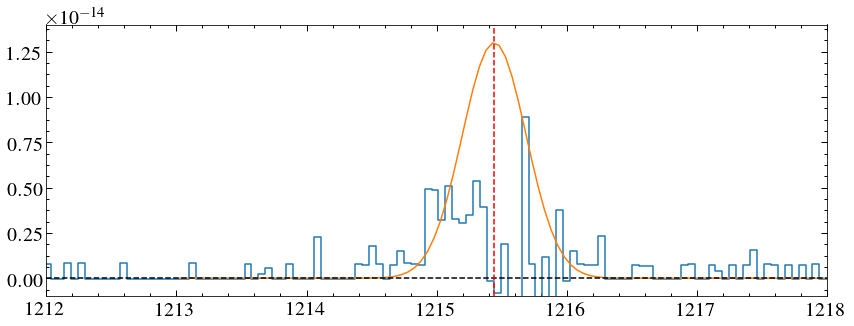

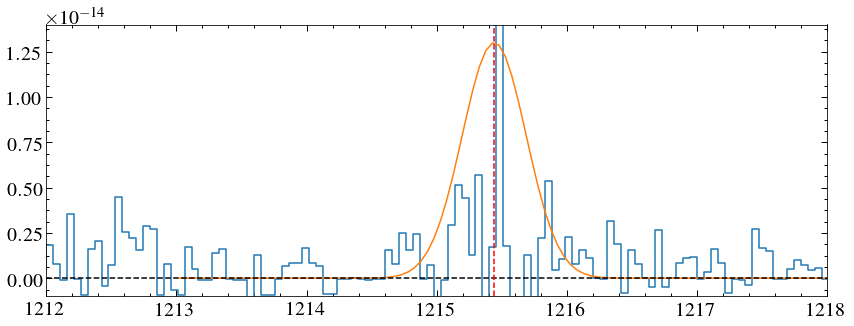

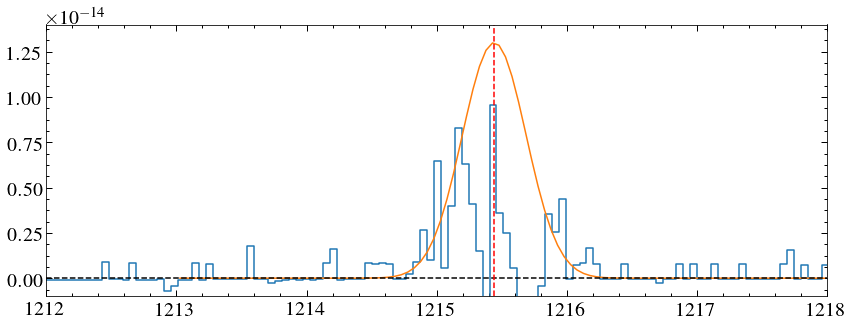

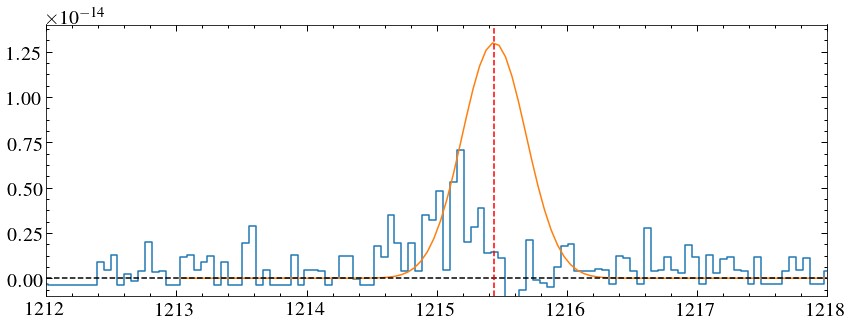

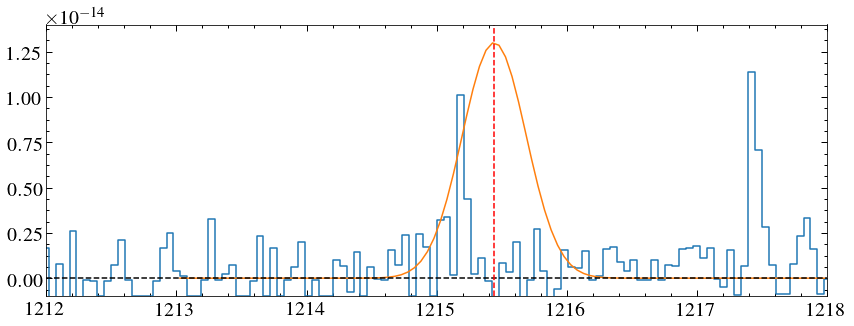

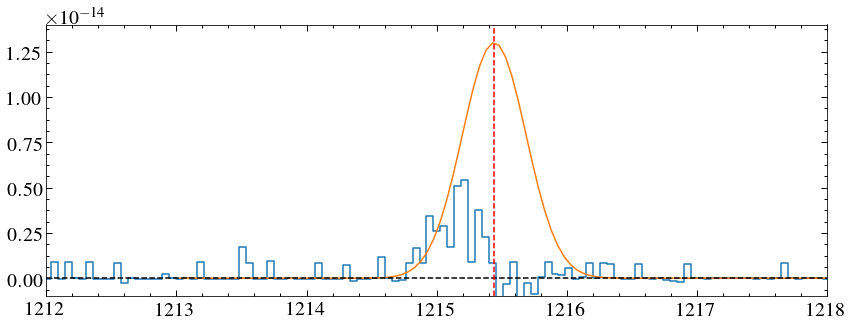

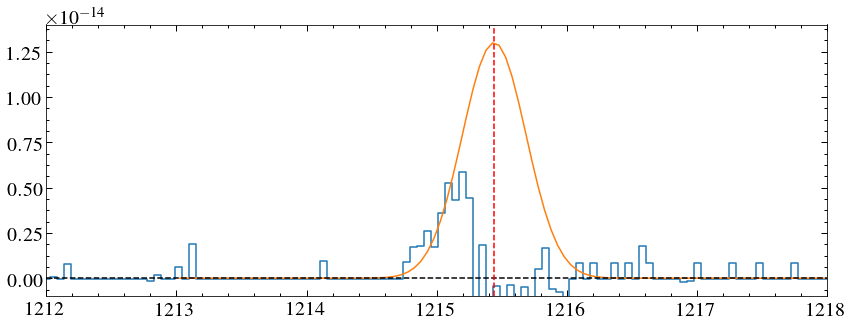

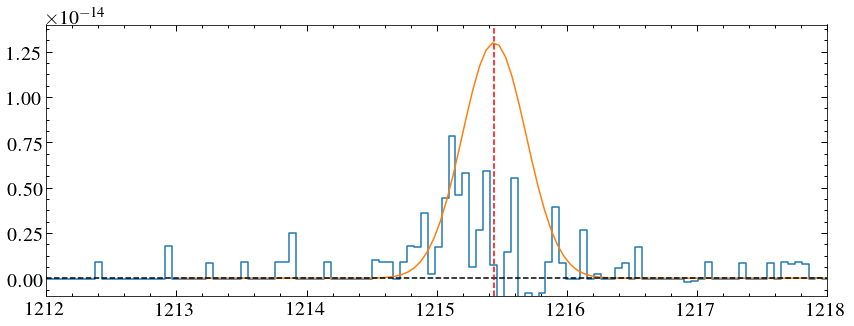

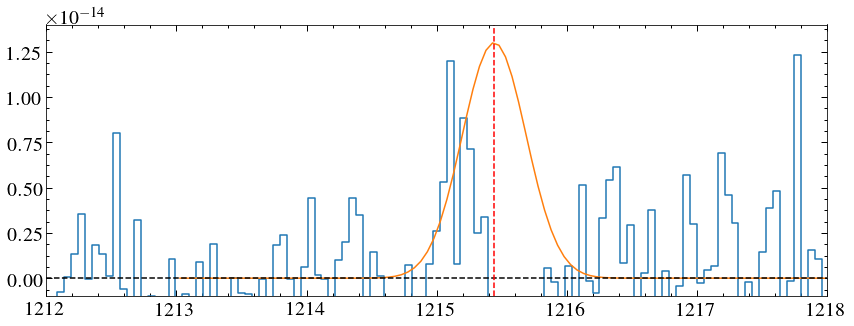

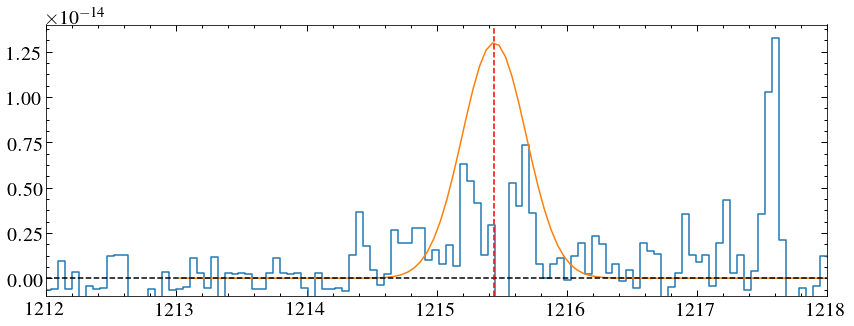

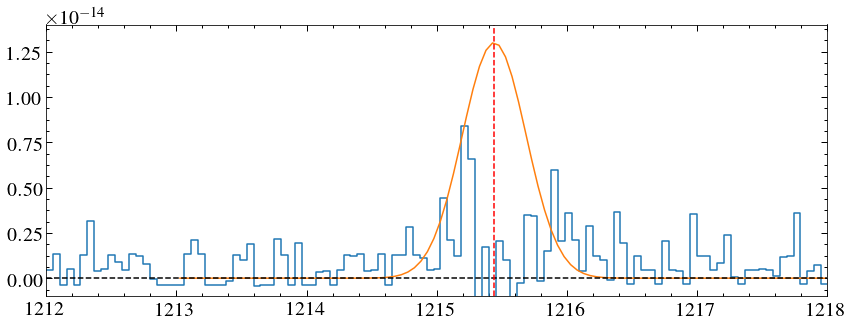

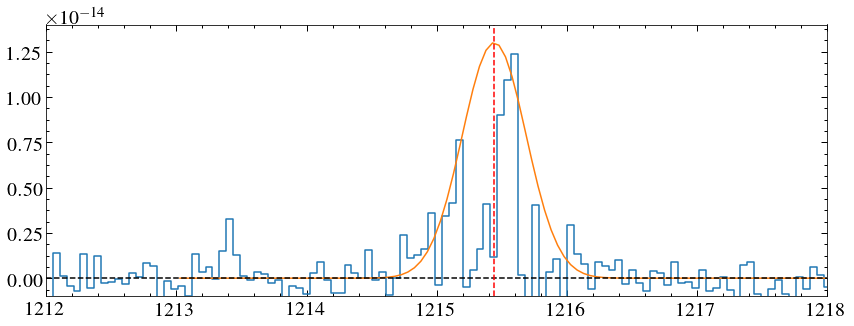

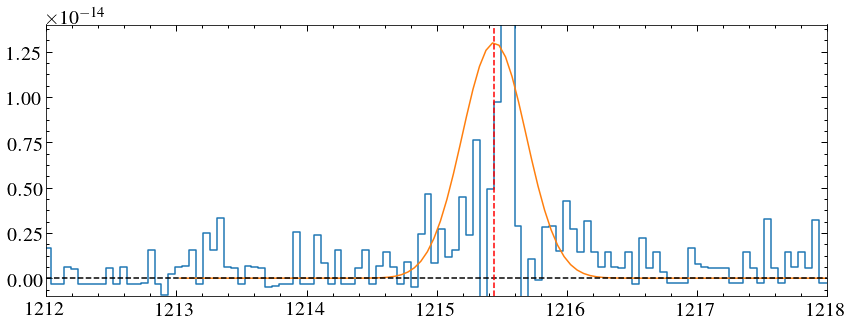

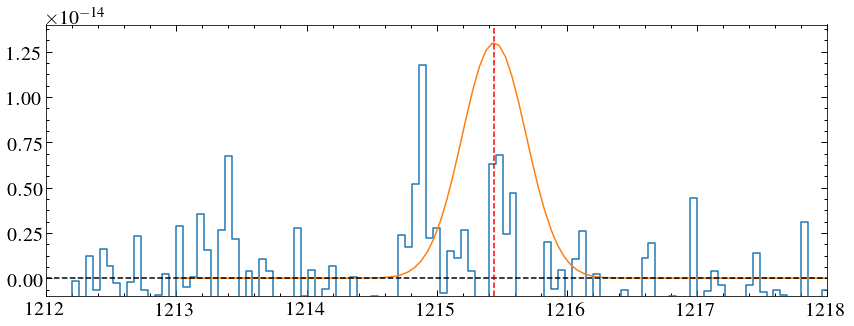

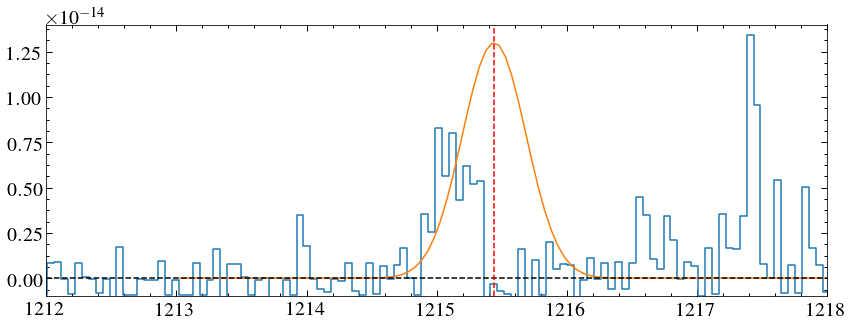

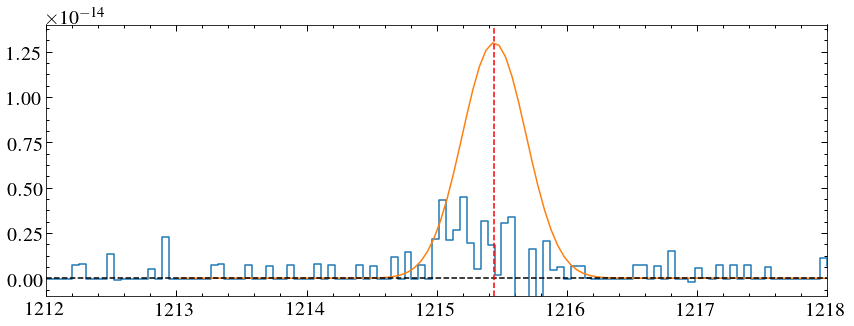

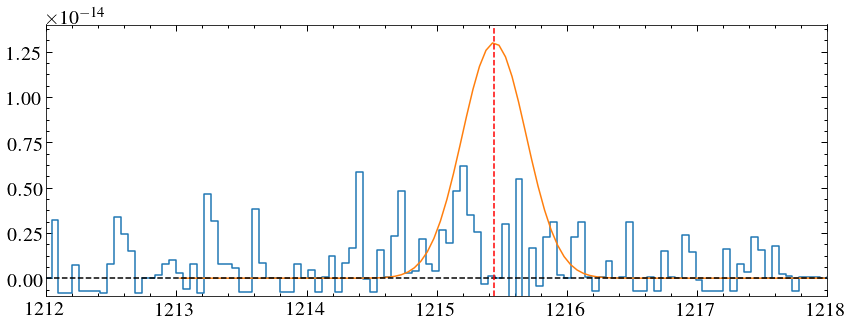

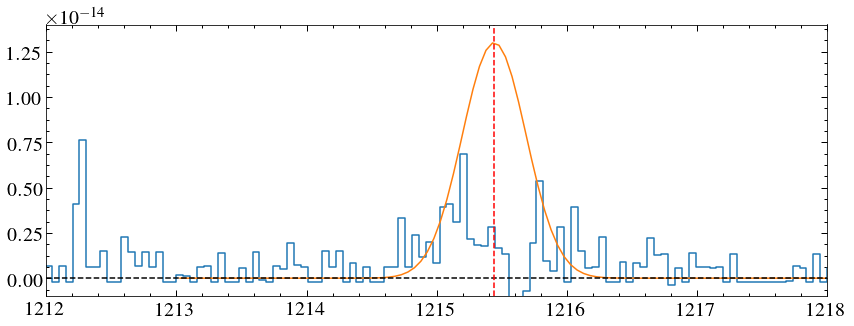

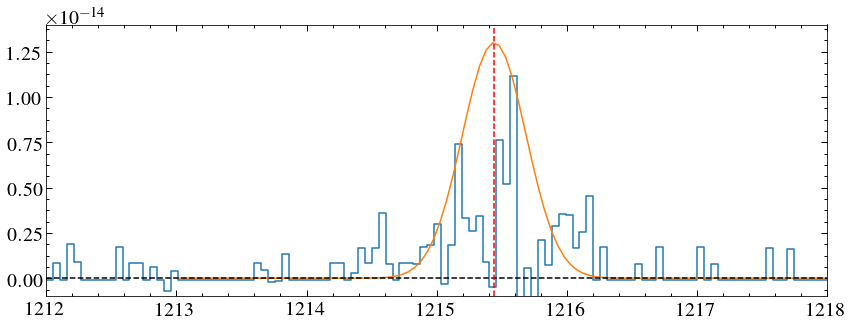

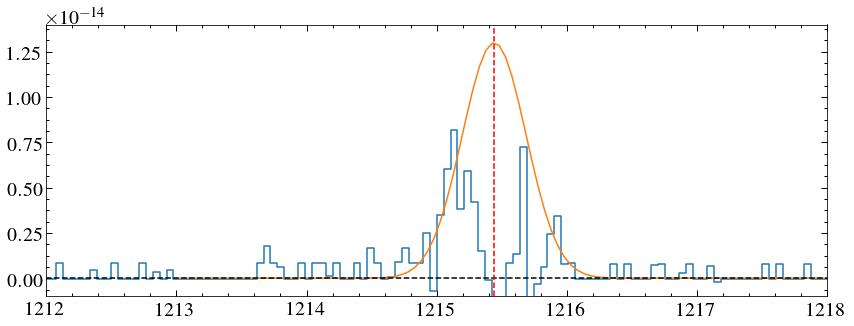

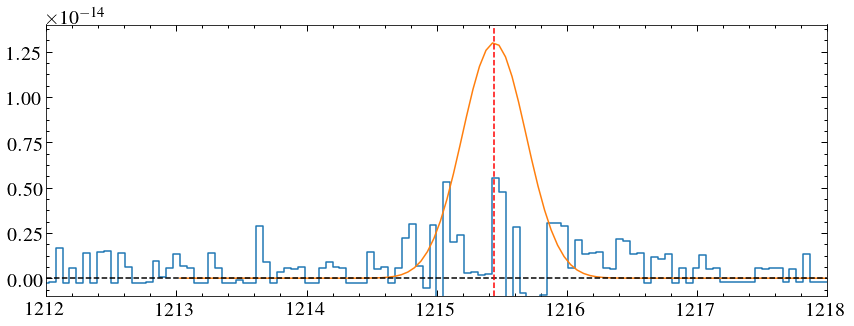

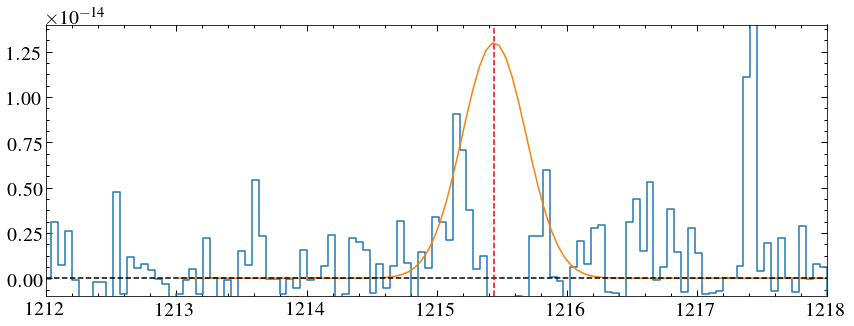

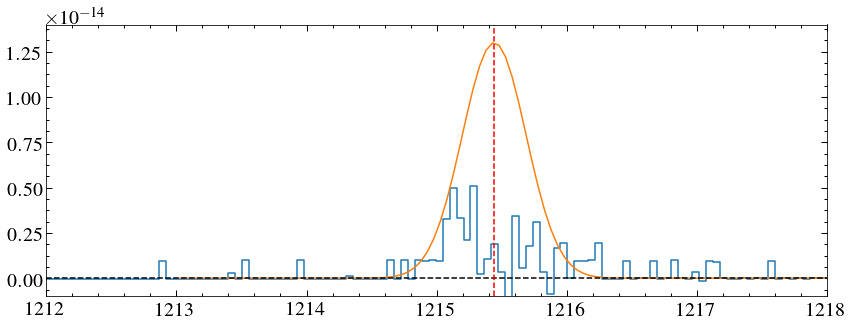

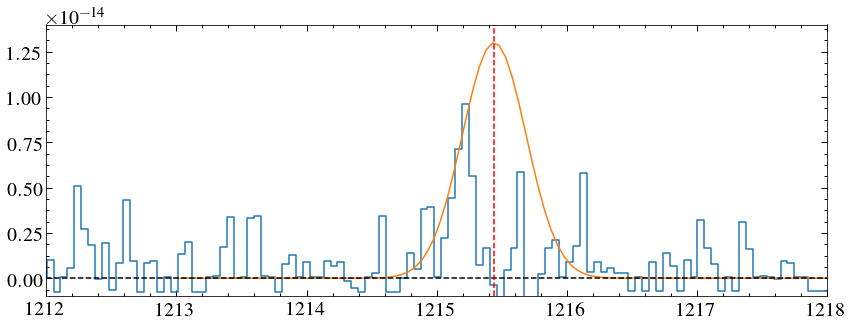

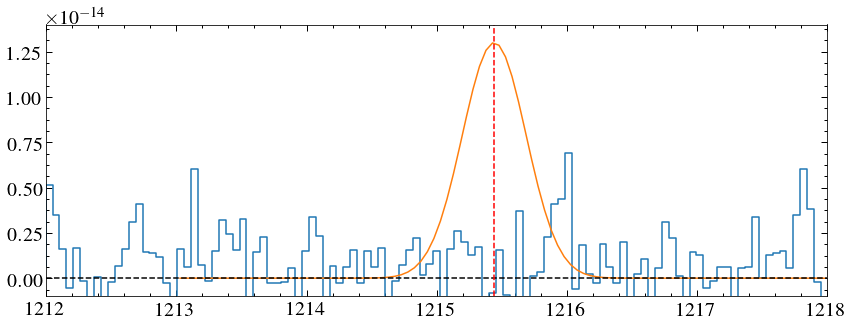

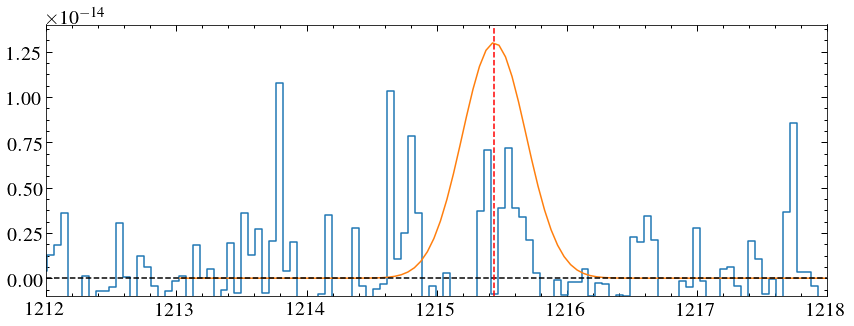

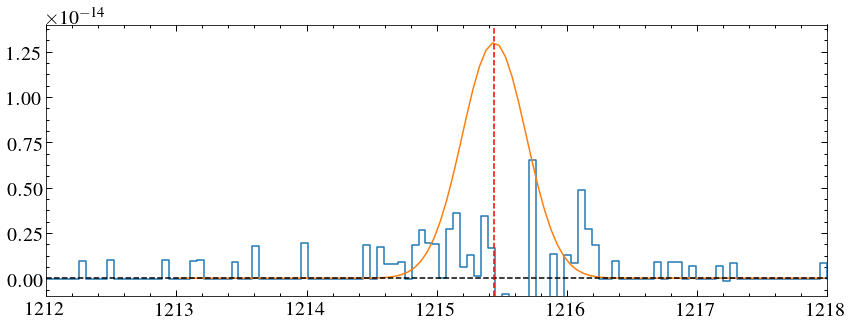

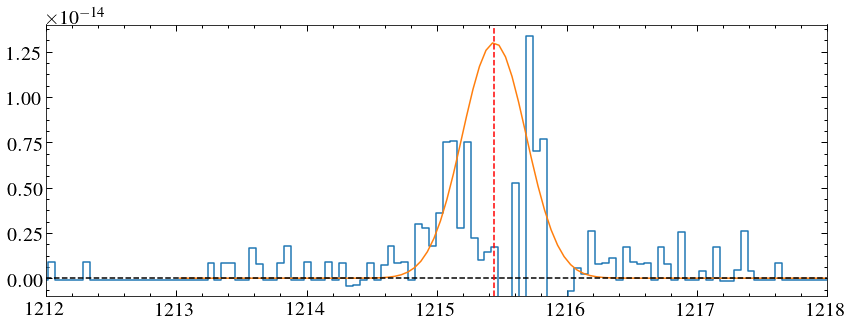

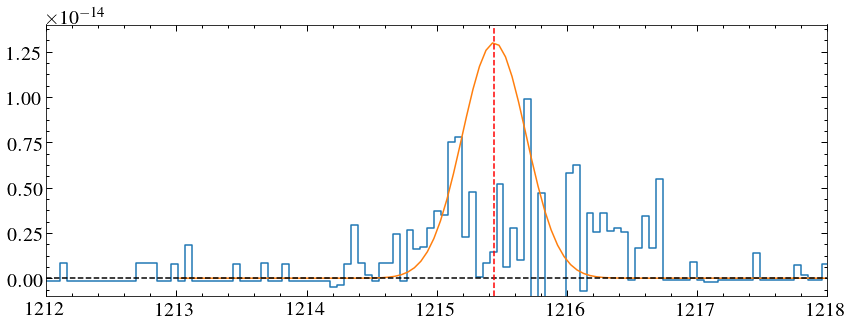

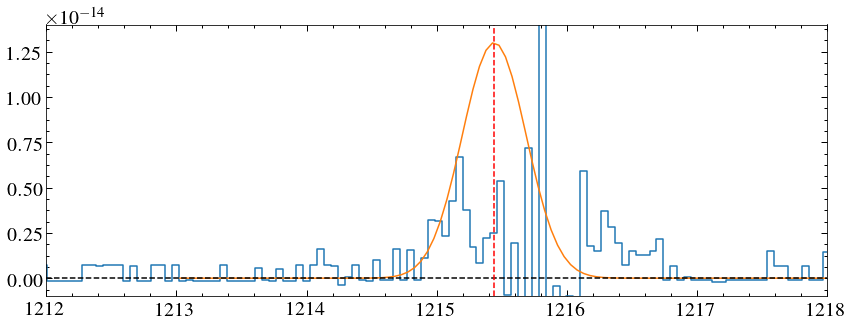

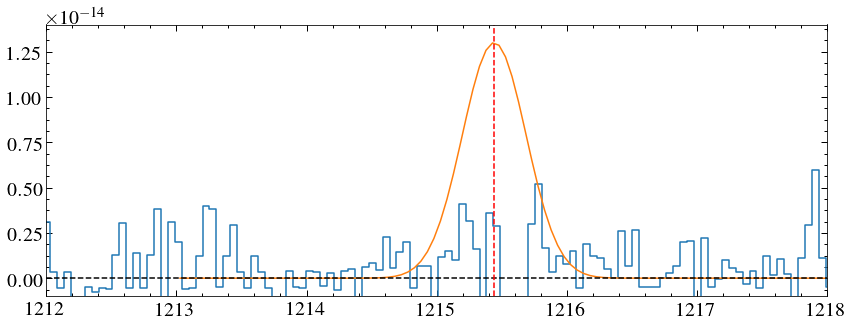

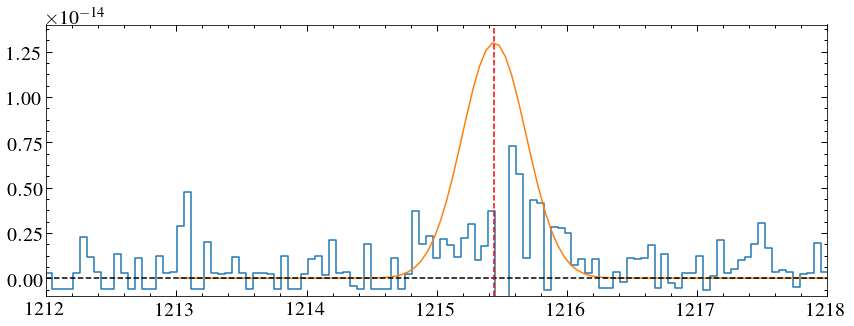

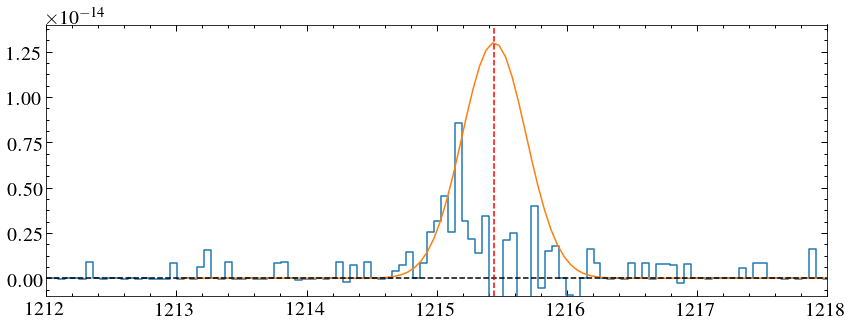

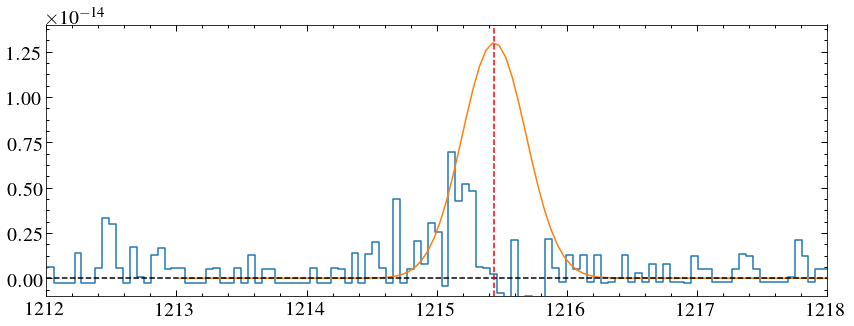

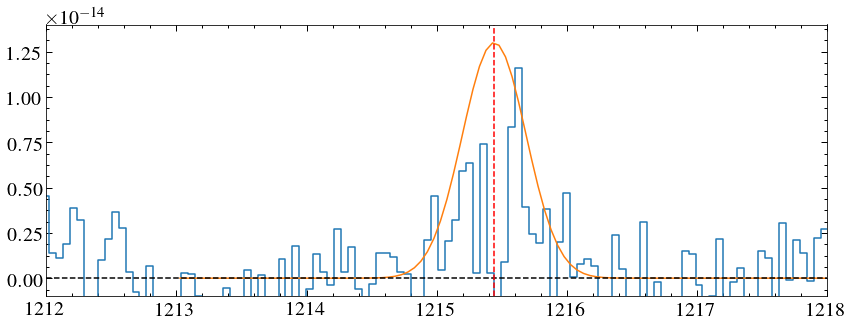

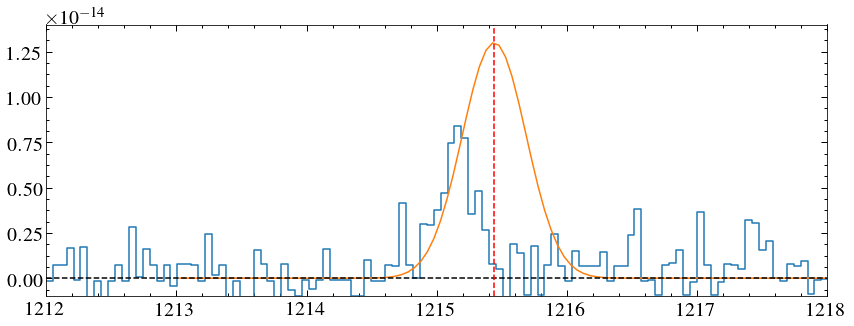

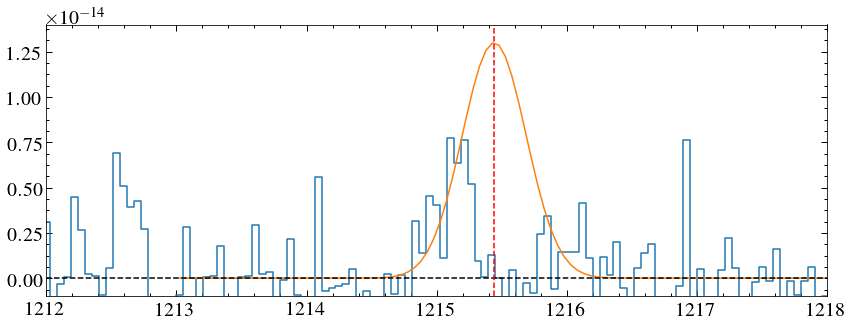

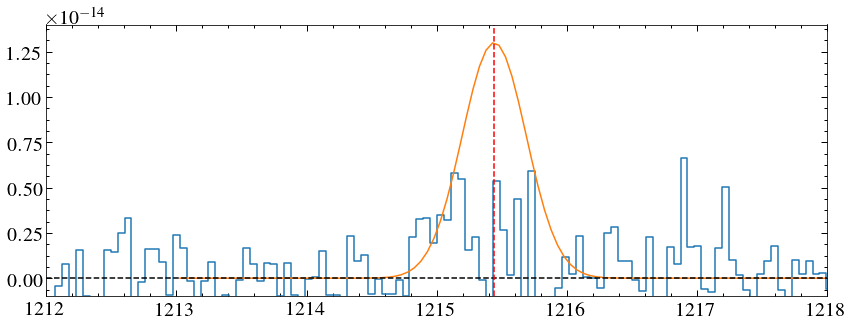

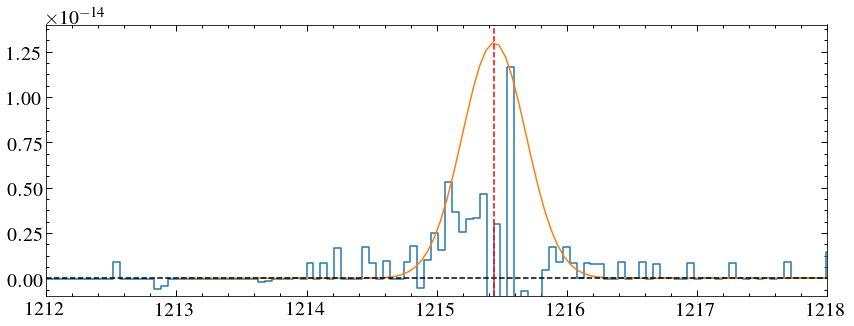

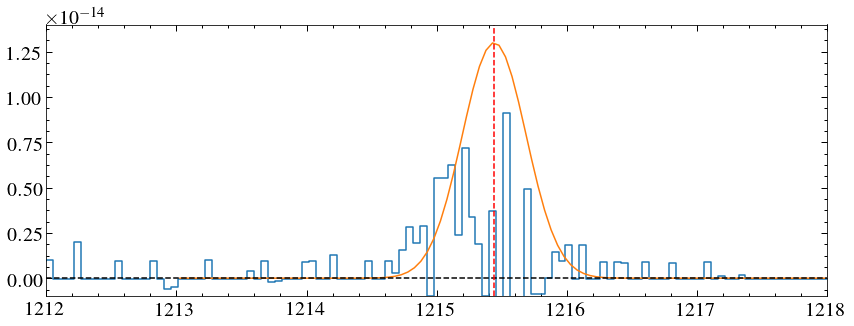

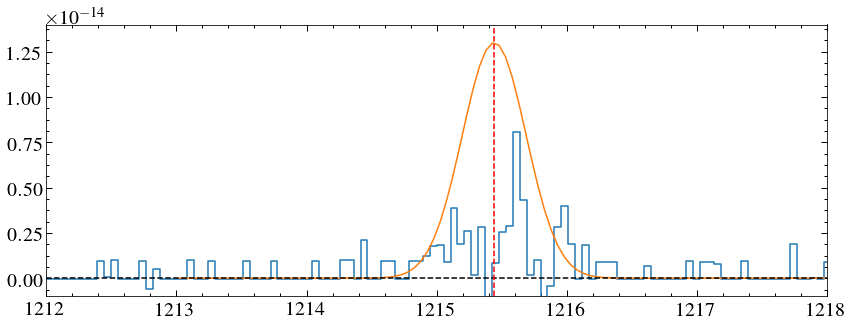

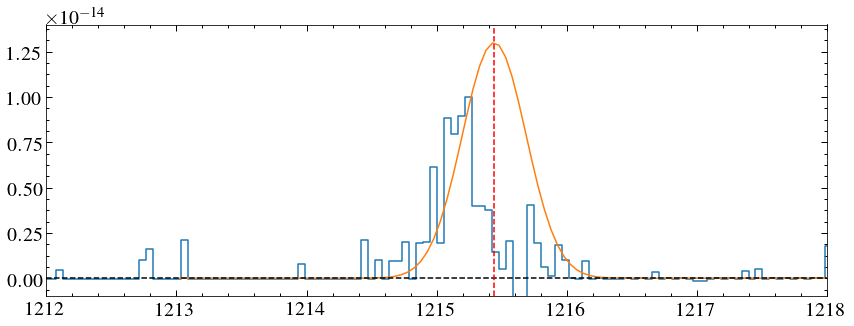

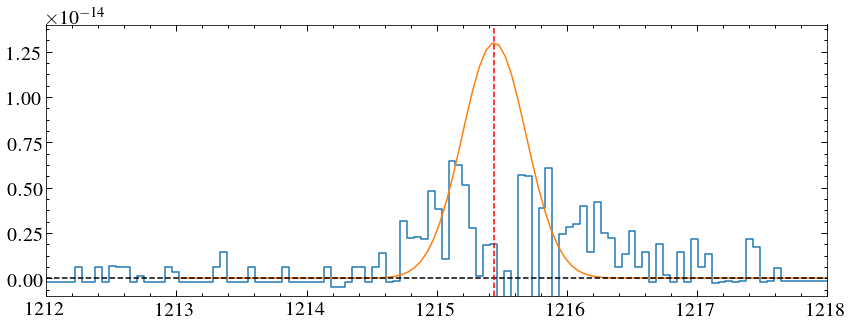

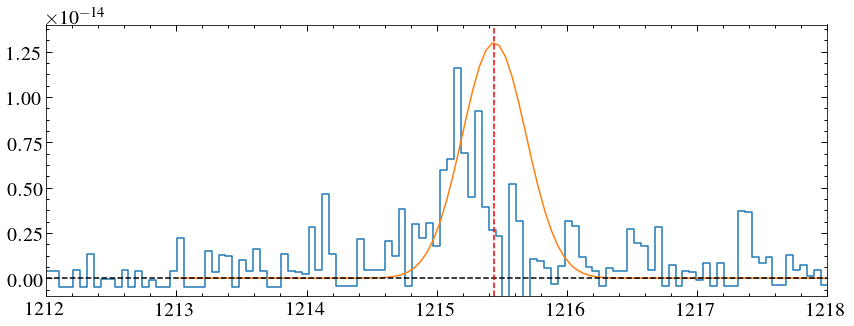

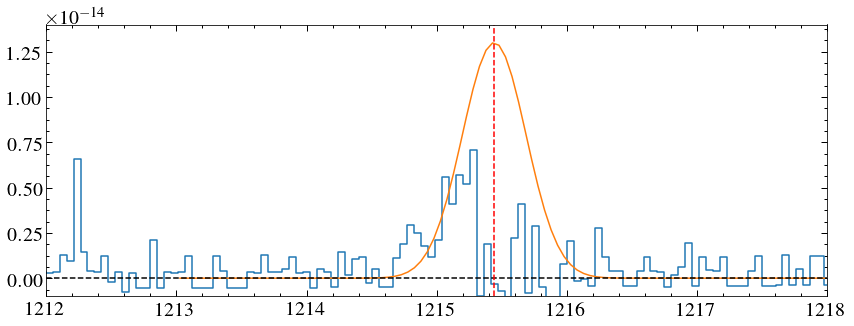

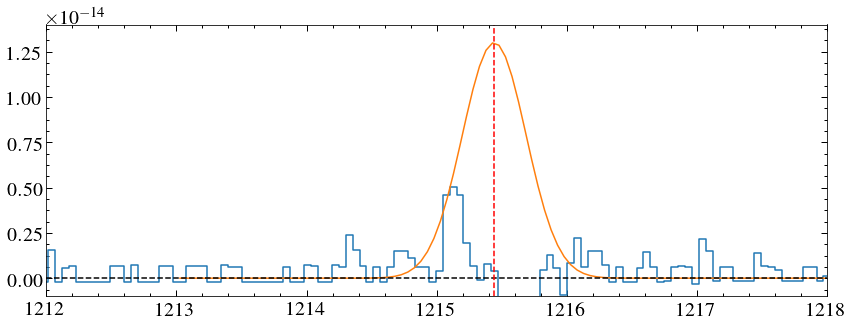

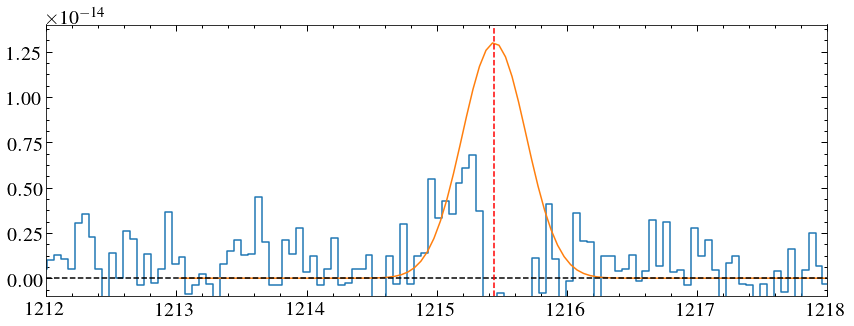

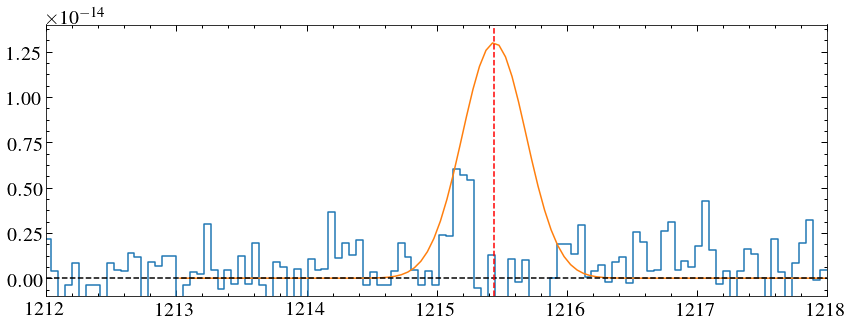

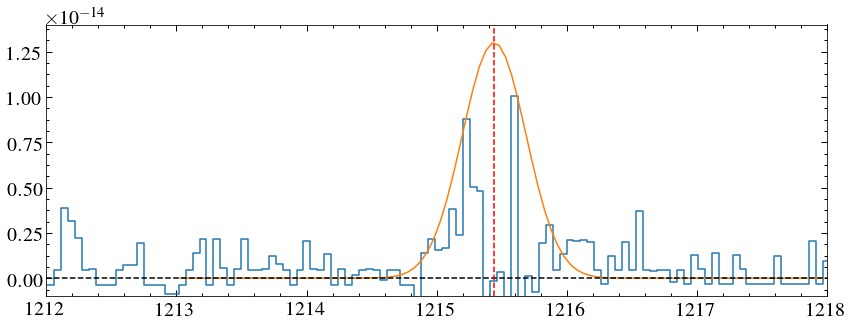

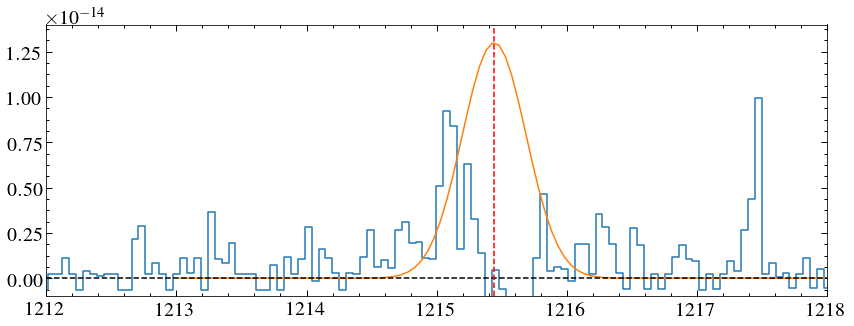

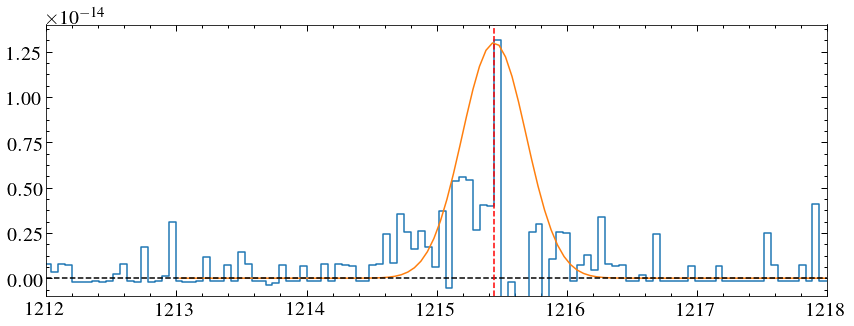

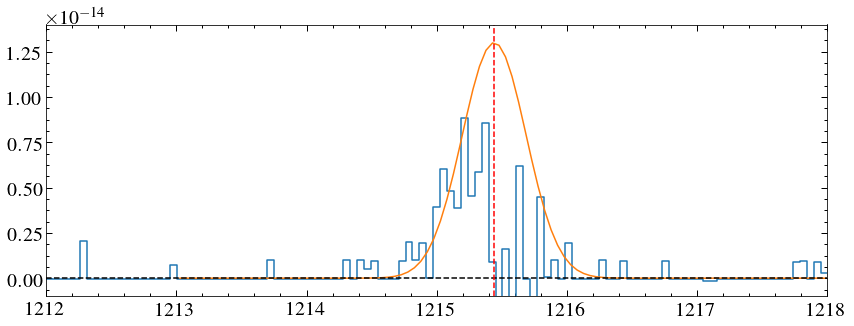

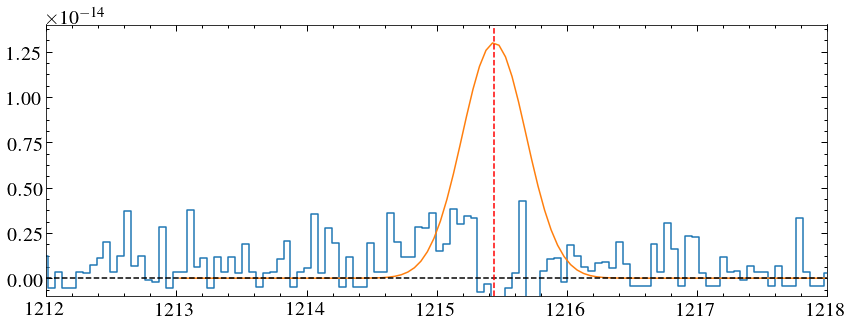

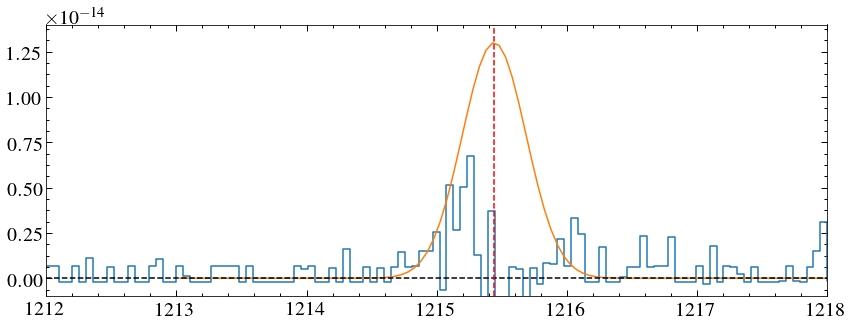

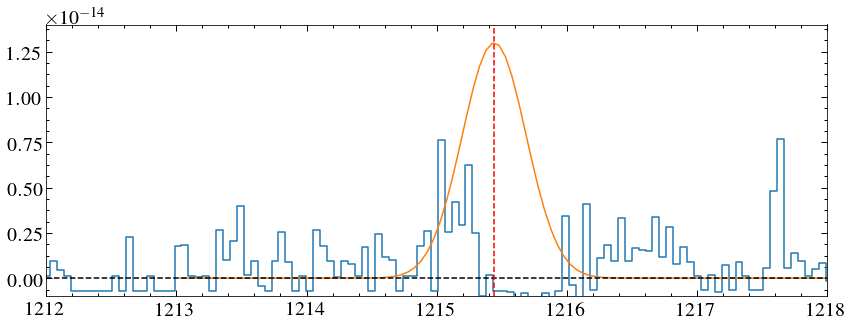

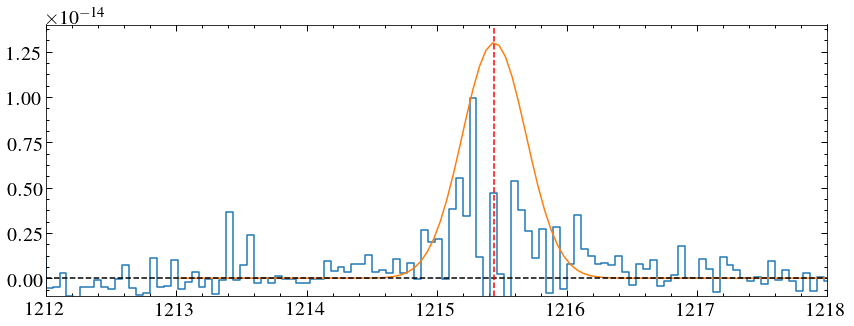

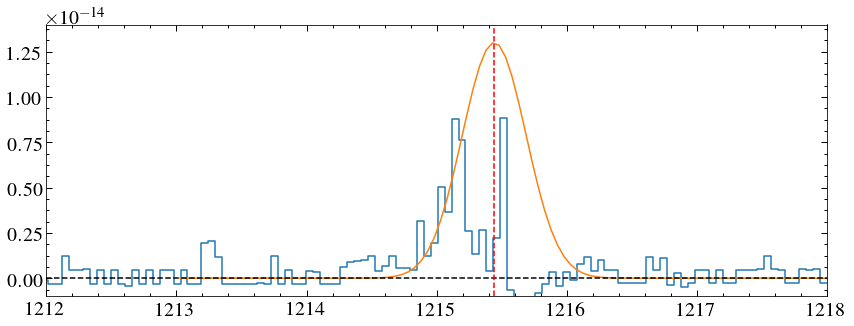

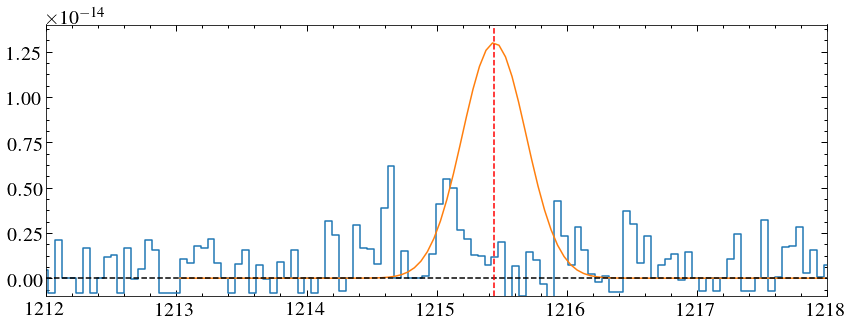

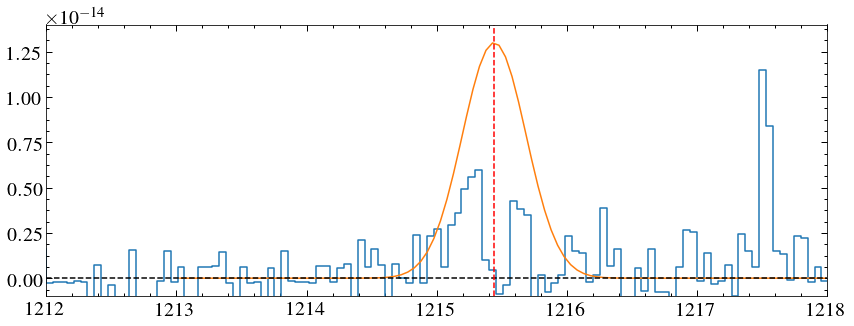

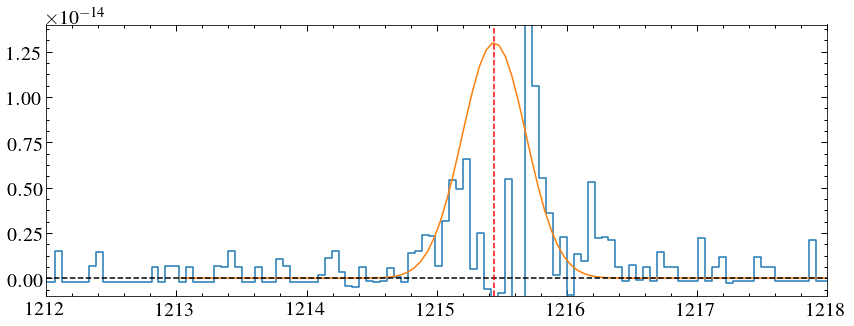

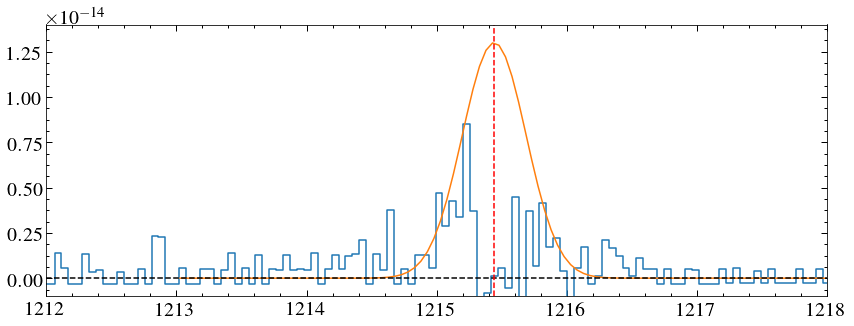

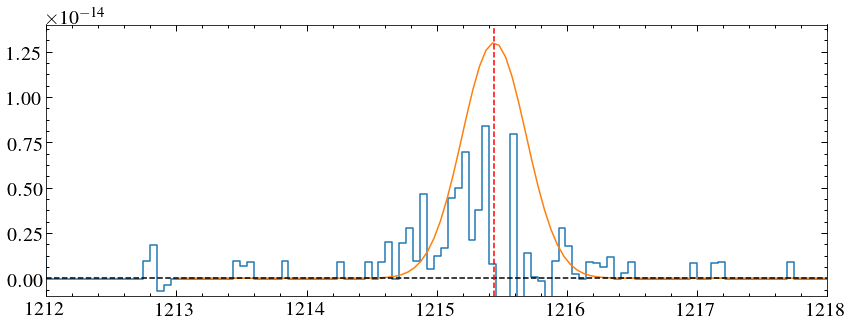

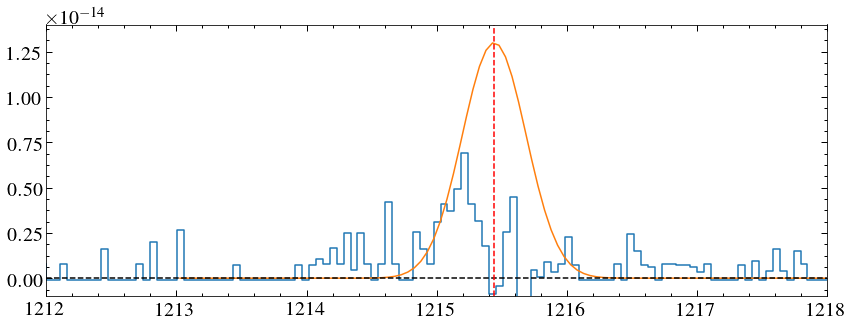

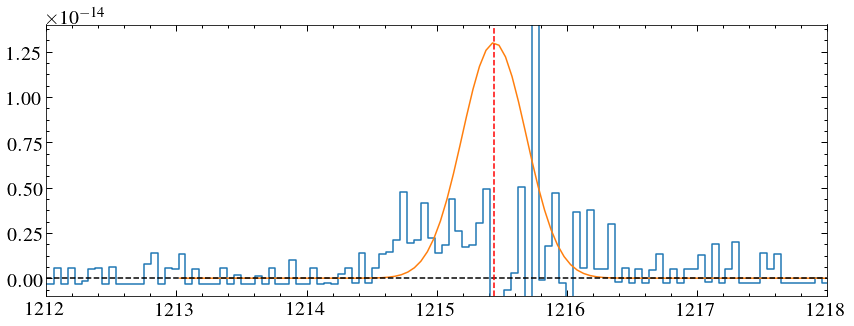

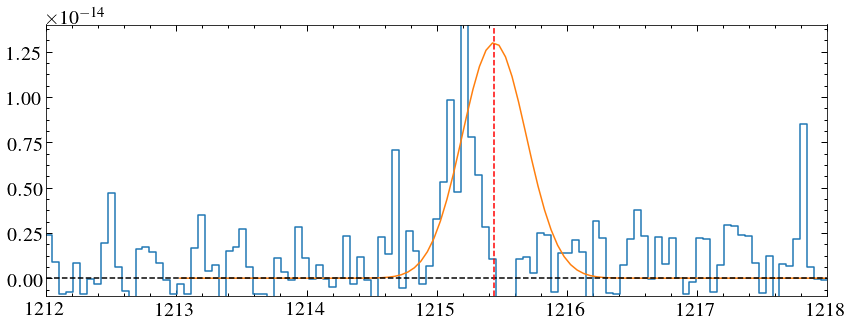

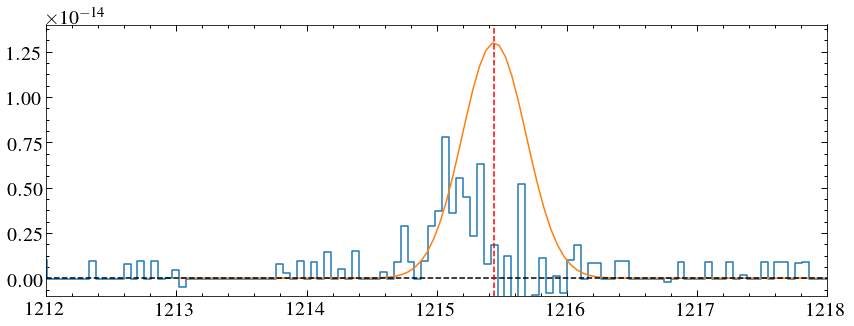

In [105]:
for x in new_x1ds:
    data = fits.getdata(x,1)[0]
    #date = fits.getheader(x, 0)['TDATEOBS']
   # if date in dates[0:3]:
    #    print(date)
    plt.step(data['WAVELENGTH'], data['FLUX'])
#    plt.step(data['WAVELENGTH'], data['ERROR'])
    plt.plot(lw, lf)
    plt.xlim(1212, 1218)

    plt.ylim(-1e-15, 1.4e-14)
    plt.axhline(0, c='k', ls ='--')
    plt.axvline(1215.44, ls ='--', c='r')
    plt.show()